In [ ]:
%%capture
pip install datasets transformers underthesea

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from underthesea import word_tokenize

No module named 'fasttext'


In [ ]:
from datasets import load_dataset

dataset = load_dataset("uitnlp/vietnamese_students_feedback")
dataset = dataset.remove_columns(['topic'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/11426 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1583 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3166 [00:00<?, ? examples/s]

# Dataset
total = 16k rows <br>
label : Positive - Neutral - Negative <br>
Positive and Negative labels account for 90%
topic : lecture - facilities - teaching program - others


 Data is almost cleaned before

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment'],
        num_rows: 3166
    })
})

In [ ]:
dataset['train'][:3]

{'sentence': ['slide giáo trình đầy đủ .',
  'nhiệt tình giảng dạy , gần gũi với sinh viên .',
  'đi học đầy đủ full điểm chuyên cần .'],
 'sentiment': [2, 2, 0]}

In [ ]:
def loadDataset(dataset):
  data = {}
  data['train'] = pd.DataFrame(dataset['train'])
  data['train'].rename(columns={'sentiment':'label'}, inplace=True)

  data['val'] = pd.DataFrame(dataset['validation'])
  data['val'].rename(columns={'sentiment':'label'}, inplace=True)

  data['test'] = pd.DataFrame(dataset['test'])
  data['test'].rename(columns={'sentiment':'label'}, inplace=True)

  return data['train'], data['val'], data['test']

train_data, val_data, test_data = loadDataset(dataset)

In [ ]:
train_data.head()

,sentence,label
0,slide giáo trình đầy đủ .,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2
2,đi học đầy đủ full điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2


### Clean for BOW and TFIDF

In [ ]:
freq_train = pd.Series(' '.join(train_data['sentence']).split()).value_counts()
freq_val = pd.Series(' '.join(val_data['sentence']).split()).value_counts()
freq_test = pd.Series(' '.join(test_data['sentence']).split()).value_counts()
freq_train.head(10)

.        11009
,         6827
viên      4803
giảng     3711
dạy       3156
thầy      3095
sinh      3082
học       2940
bài       2336
tình      2266
Name: count, dtype: int64

In [ ]:
less_5_freq_train = freq_train[freq_train <= 10].index
less_5_freq_train

Index(['chí', 'chả', 'tóm', 'trưởng', 'tân', 'trị', 'khắt', 'kit', 'môi',
       'phạm',
       ...
       'mỉm', 'tựu', '9dot5', 'case', 'study', 'av1', 'av2', 'av3', 'kệ',
       'ráng'],
      dtype='object', length=1707)

In [ ]:
#remove words have less frequent in dataset
def remove_less_freq(df:pd.DataFrame, freq:int):
  freq_data = pd.Series(' '.join(df['sentence']).split()).value_counts()
  words_less_freq = freq_data[freq_data <= freq].index

  def filter_sentence(sentence:str):
    return ' '.join([word for word in sentence.split() if word not in words_less_freq])

  df['sentence'] = df['sentence'].apply(filter_sentence)
  return df

train_data = remove_less_freq(train_data, 5)
val_data = remove_less_freq(val_data, 5)
test_data = remove_less_freq(test_data, 5)

In [ ]:
freq_train = pd.Series(' '.join(train_data['sentence']).split()).value_counts()
less_5_freq_train = freq_train[freq_train <=10]
less_5_freq_train

trưởng    10
chả       10
bó        10
tóm       10
copy      10
          ..
vẽ         6
rãi        6
lao        6
đặn        6
thất       6
Name: count, Length: 168, dtype: int64

In [ ]:
from imblearn.over_sampling import RandomOverSampler

train_data2 = train_data.copy()
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(train_data2['sentence'].values.reshape(-1, 1), train_data2['label'])

# Create a new DataFrame with the resampled data
resampled_data = pd.DataFrame({'sentence': X_resampled.flatten(), 'label': y_resampled})

print(f"Original data length: {len(train_data2)}")
print(f"Resampled data length: {len(resampled_data)}")

Original data length: 11426
Resampled data length: 16929


#Vectorization
> BOW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=True, max_df = 0.85,ngram_range=(1,2))
bow_train_features = vectorizer.fit_transform(train_data['sentence'])
bow_test_features = vectorizer.transform(test_data['sentence'])

In [ ]:
#vectorizer.get_feature_names_out()

In [ ]:
bow_train_features.shape

(11426, 29452)

> TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase = True, max_df = 0.85)
tfidf_vectorizer.fit_transform(train_data['sentence'])


<11426x955 sparse matrix of type '<class 'numpy.float64'>'
	with 131299 stored elements in Compressed Sparse Row format>

In [ ]:
len(tfidf_vectorizer.vocabulary_)

955

> phoBERT

In [ ]:
z = train_data.apply(lambda x: word_tokenize(x['sentence'], format='text'), axis=1)
z.head()

0                            slide giáo_trình đầy_đủ .
1       nhiệt_tình giảng_dạy , gần_gũi với sinh_viên .
2                      đi học đầy_đủ điểm chuyên cần .
3    chưa áp_dụng công_nghệ_thông_tin và các thiết_...
4    thầy giảng bài hay , có nhiều bài_tập ví_dụ ng...
dtype: object

In [ ]:
phobertTokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
train_data_phobert = train_data.apply(lambda x: word_tokenize(x['sentence'], format = 'text'), axis=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
input_ids = []
attention_masks = []

for sent in list(train_data_phobert):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = phobertTokenizer.encode_plus(
                        sent,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64, # only few sentences have the length > 64 (14)
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'tf',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Evaluation

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# A function to plot and print result
def printResult(y_pred, y_prob):
    acc = accuracy_score(test_data["label"], y_pred)
    # Result
    print("Accuracy: {:.2f}".format(acc*100),end='\n\n')
    cm = confusion_matrix(test_data["label"],y_pred)
    print('Confusion Matrix:\n', cm)
    print(classification_report(test_data["label"],y_pred))


# Naive bayes

In [ ]:
model = MultinomialNB() #class_prior=np.array([0.45, 0.1, 0.45])
# Training
model.fit(bow_train_features.toarray(), train_data["label"])

# Evaluation
y_pred_bow_nb = model.predict(bow_test_features.toarray())

y_prob_bow_nb = model.predict_proba(bow_test_features.toarray())[:,1]

In [ ]:
printResult(y_pred_bow_nb, y_prob_bow_nb)

Accuracy: 85.79

Confusion Matrix:
 [[1312    0   97]
 [ 104    4   59]
 [ 188    2 1400]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1409
           1       0.67      0.02      0.05       167
           2       0.90      0.88      0.89      1590

    accuracy                           0.86      3166
   macro avg       0.79      0.61      0.60      3166
weighted avg       0.85      0.86      0.84      3166



In [ ]:
resampled_data

,sentence,label
0,slide giáo trình đầy đủ .,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2
2,đi học đầy đủ điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2
...,...,...
16924,không có hoạt động giảng dạy nào không hài lòng .,1
16925,cô đi bài tập hơi chậm nhưng như vậy cũng được .,1
16926,không có gì ạ .,1
16927,cô dạy hay nhưng hơi nhanh .,1


In [ ]:
vectorizer_2 = CountVectorizer(lowercase=True, max_df = 0.85,ngram_range=(1,2))
bow_train_features = vectorizer.fit_transform(resampled_data['sentence'])
bow_test_features = vectorizer.transform(test_data['sentence'])

In [ ]:
model_2 = MultinomialNB(class_prior=np.array([0.4, 0.2, 0.4])) #
# Training
model_2.fit(bow_train_features, resampled_data['label'])

# Evaluation
y_pred_bow_nb = model_2.predict(bow_test_features.toarray())

y_prob_bow_nb = model_2.predict_proba(bow_test_features.toarray())[:,1]

Trying to apply over-sampling for minority(neutral) label <br>
The recall of neutral label was increased significantly (0.02 to 0.27) but accuracy decreased a bit (1%).

In [ ]:
printResult(y_pred_bow_nb, y_prob_bow_nb)

Accuracy: 84.18

Confusion Matrix:
 [[1248   69   92]
 [  77   45   45]
 [ 169   49 1372]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1409
           1       0.28      0.27      0.27       167
           2       0.91      0.86      0.89      1590

    accuracy                           0.84      3166
   macro avg       0.67      0.67      0.67      3166
weighted avg       0.84      0.84      0.84      3166



# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
# Training
model.fit(bow_train_features, resampled_data["label"])

# Evaluation
y_pred_bow_dt = model.predict(bow_test_features.toarray())

y_prob_bow_dt = model.predict_proba(bow_test_features.toarray())[:,1]

In [ ]:
printResult(y_pred_bow_dt, y_prob_bow_dt)

Accuracy: 83.99

Confusion Matrix:
 [[1194   82  133]
 [  51   73   43]
 [ 137   61 1392]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1409
           1       0.34      0.44      0.38       167
           2       0.89      0.88      0.88      1590

    accuracy                           0.84      3166
   macro avg       0.70      0.72      0.71      3166
weighted avg       0.85      0.84      0.84      3166



# MLP

In [ ]:
model = MLPClassifier(solver='adam', alpha=2e-4, hidden_layer_sizes=(5, 2), max_iter=400)

model.fit(bow_train_features, resampled_data["label"])

# Evaluation
y_pred_bow_mlp = model.predict(bow_test_features.toarray())

y_prob_bow_mlp = model.predict_proba(bow_test_features.toarray())[:,1]

In [ ]:
printResult(y_pred_bow_mlp, y_prob_bow_mlp)

Accuracy: 86.39

Confusion Matrix:
 [[1221   33  155]
 [  47   49   71]
 [  81   44 1465]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1409
           1       0.39      0.29      0.33       167
           2       0.87      0.92      0.89      1590

    accuracy                           0.86      3166
   macro avg       0.72      0.69      0.70      3166
weighted avg       0.86      0.86      0.86      3166



# ANN

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [ ]:
tokenizer = Tokenizer(num_words=1000, oov_token='<UNK>')
tokenizer.fit_on_texts(resampled_data['sentence'])

In [ ]:
tokenizer.word_counts

In [ ]:
sentences = tokenizer.texts_to_sequences(resampled_data['sentence'])
sentences = pad_sequences(sentences, maxlen=64, padding='post')

labels = to_categorical(list(resampled_data['label']), num_classes=3)

In [ ]:
val_sentences = tokenizer.texts_to_sequences(val_data['sentence'])
val_sentences = pad_sequences(val_sentences, maxlen=64, padding='post')

val_labels = to_categorical(list(val_data['label']), num_classes=3)

In [ ]:
test_sentences = tokenizer.texts_to_sequences(test_data['sentence'])
test_sentences = pad_sequences(test_sentences, maxlen=64, padding='post')

test_labels = to_categorical(list(test_data['label']), num_classes=3)

In [ ]:
sentences

array([[141,  50,  47, ...,   0,   0,   0],
       [ 18,  13,   3, ...,   0,   0,   0],
       [ 92,   5, 119, ...,   0,   0,   0],
       ...,
       [  7,   9,  69, ...,   0,   0,   0],
       [ 24,   6,  39, ...,   0,   0,   0],
       [165,  91,  56, ...,   0,   0,   0]], dtype=int32)

In [ ]:
vocab_size = 1000
embedding_dim = 16
max_length = 64

model4 = Sequential([
    Embedding(input_dim = vocab_size,output_dim = embedding_dim, input_length = max_length),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model4.compile(loss=CategoricalCrossentropy(),
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy'],
              run_eagerly=True)


In [ ]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 64, 16)            16000     
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 16643 (65.01 KB)
Trainable params: 16643 (65.01 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
history = model4.fit(sentences, labels,validation_data=(val_sentences, val_labels),
           epochs = 16,verbose=2)

Epoch 1/16
530/530 - 37s - loss: 0.5904 - accuracy: 0.7563 - val_loss: 0.3827 - val_accuracy: 0.8572 - 37s/epoch - 70ms/step
Epoch 2/16
530/530 - 21s - loss: 0.3492 - accuracy: 0.8862 - val_loss: 0.4795 - val_accuracy: 0.8275 - 21s/epoch - 39ms/step
Epoch 3/16
530/530 - 19s - loss: 0.3148 - accuracy: 0.8965 - val_loss: 0.4462 - val_accuracy: 0.8459 - 19s/epoch - 36ms/step
Epoch 4/16
530/530 - 23s - loss: 0.2843 - accuracy: 0.9093 - val_loss: 0.5210 - val_accuracy: 0.8080 - 23s/epoch - 43ms/step
Epoch 5/16
530/530 - 20s - loss: 0.2550 - accuracy: 0.9172 - val_loss: 0.5749 - val_accuracy: 0.8042 - 20s/epoch - 37ms/step
Epoch 6/16
530/530 - 19s - loss: 0.2440 - accuracy: 0.9197 - val_loss: 0.5166 - val_accuracy: 0.8534 - 19s/epoch - 35ms/step
Epoch 7/16
530/530 - 20s - loss: 0.2298 - accuracy: 0.9217 - val_loss: 0.5445 - val_accuracy: 0.8781 - 20s/epoch - 37ms/step
Epoch 8/16
530/530 - 18s - loss: 0.2099 - accuracy: 0.9292 - val_loss: 0.5544 - val_accuracy: 0.8541 - 18s/epoch - 34ms/step


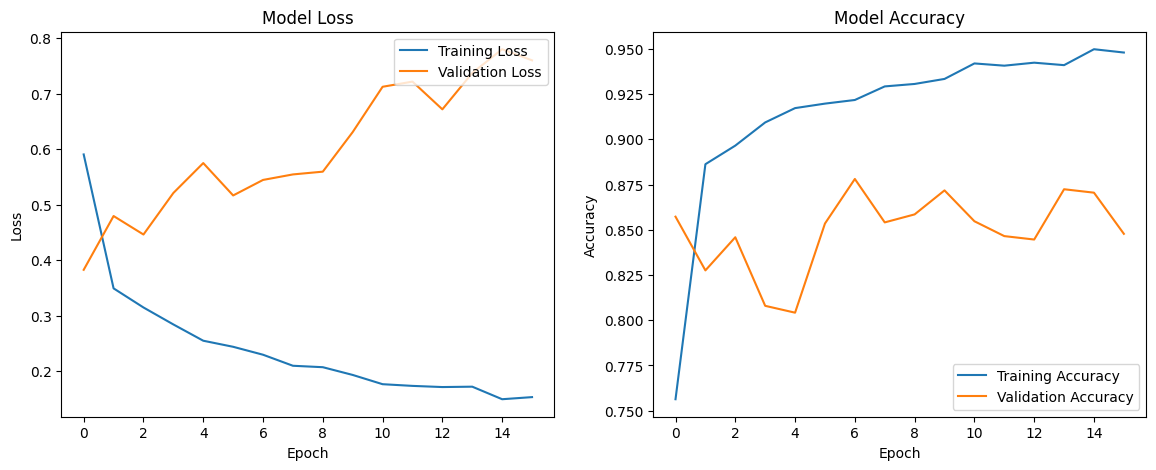

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, train_loss, label='Training Loss')
plt.plot(history.epoch, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, train_accuracy, label='Training Accuracy')
plt.plot(history.epoch, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
model4.evaluate(test_sentences, test_labels)

99/99 [==============================] - 2s 18ms/step - loss: 1.0656 - accuracy: 0.8402


[1.0655789375305176, 0.8401768803596497]